In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from bioinfokit.analys import stat
from scipy import stats


import warnings
warnings.filterwarnings('ignore')

## Loading dataset

In [6]:
df = pd.read_csv("datasetGenerate\datasettrade-weatherCities-weatherIndian_v2.csv")
df.head()

,Unnamed: 0,YEAR,Commodity,Import,Export,Difference,maxtempC,mintempC,totalSnow_cm,sunHour,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,Temperature_Mean
0,0,2010,"AIRCRAFT, SPACECRAFT, AND PARTS THEREOF.",3437.53,1666.05,-1771.48,32.194521,21.22911,0.0,10.863733,...,13.008975,25.181122,57.080294,0.066695,1007.942865,26.095034,9.301712,195.274229,8.766053,25.189167
1,1,2010,ALBUMINOIDAL SUBSTANCES; MODIFIED STARCHES; GL...,225.04,240.76,15.72,32.194521,21.22911,0.0,10.863733,...,13.008975,25.181122,57.080294,0.066695,1007.942865,26.095034,9.301712,195.274229,8.766053,25.189167
2,2,2010,ALUMINIUM AND ARTICLES THEREOF.,2209.93,1242.76,-967.17,32.194521,21.22911,0.0,10.863733,...,13.008975,25.181122,57.080294,0.066695,1007.942865,26.095034,9.301712,195.274229,8.766053,25.189167
3,3,2010,ANIMAL OR VEGETABLE FATS AND OILS AND THEIR CL...,6551.08,743.17,-5807.91,32.194521,21.22911,0.0,10.863733,...,13.008975,25.181122,57.080294,0.066695,1007.942865,26.095034,9.301712,195.274229,8.766053,25.189167
4,4,2010,ARMS AND AMMUNITION; PARTS AND ACCESSORIES THE...,4.99,17.01,12.02,32.194521,21.22911,0.0,10.863733,...,13.008975,25.181122,57.080294,0.066695,1007.942865,26.095034,9.301712,195.274229,8.766053,25.189167


In [7]:
# Drop the Unnamed: Column
df = df.drop("Unnamed: 0", axis=1)


## Find the realtionship with Commodity is AIRCRAFT, SPACECRAFT, AND PARTS THEREOF.

In [8]:
df1 = df.loc[df["Commodity"] == "AIRCRAFT, SPACECRAFT, AND PARTS THEREOF."]
df1.head()

,YEAR,Commodity,Import,Export,Difference,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,Temperature_Mean
0,2010,"AIRCRAFT, SPACECRAFT, AND PARTS THEREOF.",3437.53,1666.05,-1771.48,32.194521,21.229110,0.0,10.863733,6.427740,...,13.008975,25.181122,57.080294,0.066695,1007.942865,26.095034,9.301712,195.274229,8.766053,25.189167
98,2011,"AIRCRAFT, SPACECRAFT, AND PARTS THEREOF.",4082.57,1745.18,-2337.39,31.720890,20.498630,0.0,10.869110,6.360274,...,14.544920,22.261844,53.820177,0.068773,1007.836159,25.561701,9.613570,191.241510,9.915996,24.710833
196,2012,"AIRCRAFT, SPACECRAFT, AND PARTS THEREOF.",4678.99,2210.19,-2468.80,31.789617,21.140027,0.0,11.007172,6.483948,...,15.630123,20.128600,50.049892,0.050488,1007.985983,26.010402,9.752818,202.373250,10.807178,24.678333
294,2013,"AIRCRAFT, SPACECRAFT, AND PARTS THEREOF.",4305.34,4585.20,279.86,31.603425,21.400342,0.0,10.896233,6.479795,...,15.537400,23.038199,52.707406,0.049426,1008.171804,26.040468,9.694064,197.371575,10.803453,24.820000
392,2014,"AIRCRAFT, SPACECRAFT, AND PARTS THEREOF.",4706.69,6159.57,1452.88,32.081164,21.623973,0.0,10.992979,6.587329,...,15.162215,20.559732,49.418750,0.038198,1009.056293,26.416553,9.774443,197.453168,10.599229,24.732500


In [9]:
# Preprocess data
df1_im = df1.drop(["YEAR", "Commodity", "Export"], axis=1)
Y = df1_im[["Import"]]
X = df1_im.iloc[:, 1:]

## Define foward selected features

This is the greedy function:
    First iteration: I will greedily choose the first attribute that gives the lowest loss. 
                     Pop this attribute out of avalable attribute.
    Second iteration: I will greedily choose the second attribute that combine with
                     the first attribute give the lowest loss. Pop this attribute out of avalable attribute.

....
    Repeat until the lowest loss at current  iteration higher than the best lowest loss.

In [11]:
# Forward Selection
def forward_selected(data, response):
    """_summary_

    Args:
        data (dataframe): data
        response (str): The Y column/label

    Returns:
        formula (str): Indicate y depends on which the attributes.
        model: The model which is fit formula and data
        selected (int): Number of attributes that y depend on
    """

    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score = best_new_score = 0.0
    iter = 0
    while remaining and current_score == best_new_score and iter < 10000:
        scores_with_candidates = []
        for candidate in remaining:
            iter += 1
            formula = f"{response} ~ {' + '.join(selected + [candidate])} + 1"
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))

        scores_with_candidates.sort()

        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score

    formula = f"{response} ~ {' + '.join(selected)} + 1"
    model = smf.ols(formula, data).fit()
    return model, formula, len(selected)


In [13]:
model, formula, p = forward_selected(df1_im, "Import")
print(model.model.formula)
model.summary()

Import ~ Temperature_Mean + visibility + HeatIndexC + FeelsLikeC + Difference + mintempC + 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Import   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     4084.
Date:                Mon, 27 Jun 2022   Prob (F-statistic):             0.0120
Time:                        04:48:49   Log-Likelihood:                -30.211
No. Observations:                   8   AIC:                             74.42
Df Residuals:                       1   BIC:                             74.98
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.212e+04   4302.431      2.817      0.217   -4.25e+04    6.68e+04
Temperature_Mean  1858.6676     45.652     40.714      0.016    1278.606    2438.729
visibility        1366.8223    159.852      8.551      0.074    -664.293    3397.938
HeatIndexC        -4.41e+04   2202.064    -20.025      0.032   -7.21e+04   -1.61e+04
FeelsLikeC        4.221e+04   2165.502     19.493      0.033    1.47e+04    6.97e+04
Difference          -0.0506      0.011     -4.632      0.135      -0.189       0.088
mintempC          -256.3637     63.615     -4.030      0.155   -1064.670     551.943
==============================================================================
Omnibus:                        0.507   Durbin-Watson:                   3.394
Prob(Omnibus):                  0.776   Jarque-Bera (JB):                0.473
Skew:                           0.114   Prob(JB):                        0.789
Kurtosis:                       1.831   Cond. No.                     1.45e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the output above, the relation ship between Import and each attributes are:
```
Import ~ Temperature_Mean + visibility + HeatIndexC + FeelsLikeC + Difference + mintempC + 1
```

The actual relationship after model fit is:
```
Import ~ 1858.6676 * Temperature_Mean + 1366.8223 * visibility + (-4.41e+04) * HeatIndexC + (4.221e+04)* FeelsLikeC + (-0.0506) *  Difference + -256.3637 * mintempC + 1 * (1.212e+04)
```

In [14]:
anova = stat()
anova.anova_stat(df=df1_im, res_var="Import", anova_model=formula)
anova.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
Temperature_Mean,1.0,1.479795e+06,1.479795e+06,1657.627087,0.015633
visibility,1.0,6.526817e+04,6.526817e+04,73.111668,0.074117
HeatIndexC,1.0,3.579734e+05,3.579734e+05,400.992274,0.031765
FeelsLikeC,1.0,3.392207e+05,3.392207e+05,379.986070,0.032630
Difference,1.0,1.915051e+04,1.915051e+04,21.451898,0.135373
mintempC,1.0,1.449798e+04,1.449798e+04,16.240248,0.154846
Residual,1.0,8.927189e+02,8.927189e+02,NaN,NaN


## F-test to check that Y is depend all attributes of formula

We use F-test to check that Y is depend all attributes of formula. And all variables are linear independent

In [17]:
def qf(p, df1, df2, ncp=0):
    """compute the value of quantile function over F distribution 
    for a sequence of numeric values. 

    Args:
        p (array_like):    lower tail probability
        df1 (_type_): Degree of the First Freedom
        df2 (_type_): Degree of the Secibd Freedom
        ncp (int, optional): Defaults to 0.

    Returns:
        array_like:     quantile corresponding to the lower tail probability q.

    """
    return stats.f.ppf(q=p, dfn=df1, dfd=df2, loc=0, scale=1) if ncp == 0 else stats.ncf.ppf(
        q=p, dfn=df1, dfd=df2, loc=0, scale=1)

In [18]:
n = X.shape[0]
alpha = 0.05
degree_of_freedom = n - p - 1

# sum of squares total,
SSTO = np.sum(np.square(Y - Y.mean()))

# sum of squares error
SSE = np.sum(np.square(model.resid))

MSE = SSE / degree_of_freedom

# Sum of residual
SSR = SSTO - SSE
MSR = SSR / degree_of_freedom

if ((MSR / MSE).item()) > qf(1 - alpha, p-1, degree_of_freedom):
    print("Y is related to all independent variables")
else:
    print("Y is not related to all independent variables")

Y is related to all independent variables


## Visualize correlation matrix attributes

In [19]:
def corrfunc(x, y, ax=None, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f"ρ = {r:.2f}", xy=(.1, .9), xycoords=ax.transAxes)

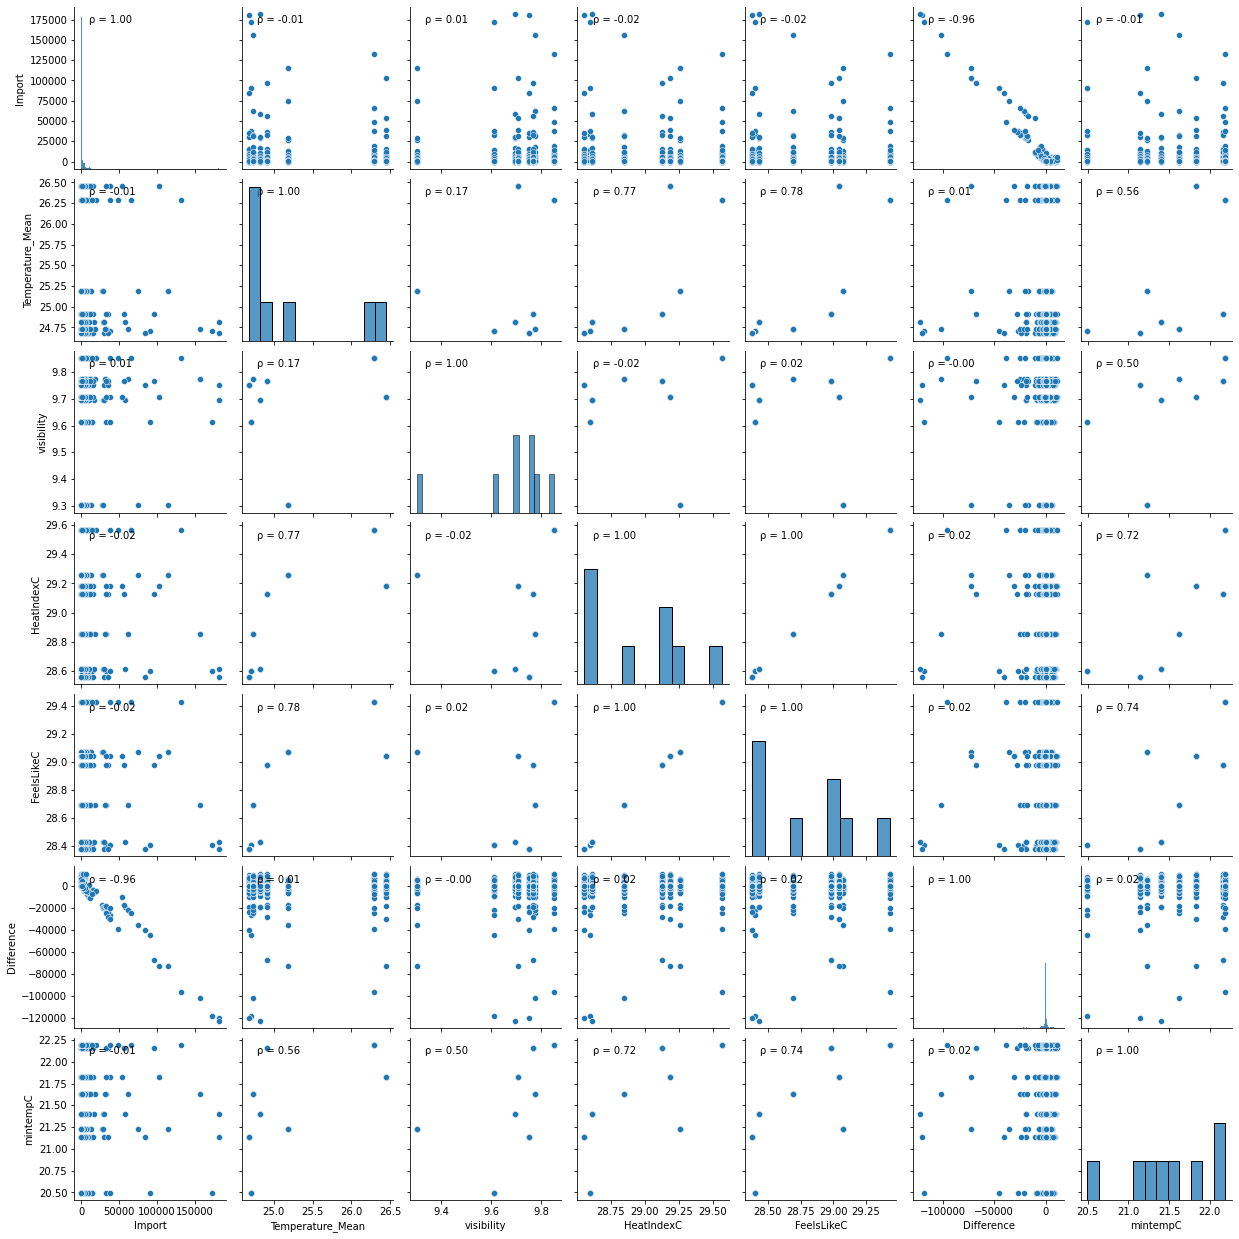

In [20]:
g = sns.pairplot(df[["Import", "Temperature_Mean", "visibility", "HeatIndexC", "FeelsLikeC", "Difference", "mintempC"]])
g.map(corrfunc)
plt.show()